In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy as sp
import os

import functools
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [49]:
def load(file_name, header=None) -> pd.DataFrame:
    """Loading dataset
    @param file_name: user input dataset
    @return: dataset
    """
    if os.path.exists(file_name) == False:
        raise ValueError("File not found")
    if header == False:
        return pd.read_csv(file_name, header=None)
    return pd.read_csv(file_name)

def copy_df(df) -> pd.DataFrame:
    """copy df to new temp df
    @param df: user input dataset
    @return: new df
    """
    return df.copy(deep=True)

def normalize_missing_values(dataset) -> pd.DataFrame:
    """normalize dataset missing values with mean for numerical columns
    @param dataset: user input dataset
    @return: normalized dataset
    """
    for col in dataset.columns:
        # print("column: ",col, "type: ", dataset[col].dtype)
        if dataset[col].dtype == 'object':
            dataset[col] = dataset[col].fillna(method='bfill')
        else:
            dataset[col] = dataset[col].fillna(dataset[col].mean()) 
    return dataset

def print_dataset(dataset):
    """print dataset inforamtion
    @param dataset: user input dataset
    @return: print dataset information via head(), info(), shape()
    """
    print(dataset.head())
    print(dataset.info())
    print(dataset.describe())
    print(dataset.columns)
    print(dataset.iloc[:, -2].value_counts())

def dummy_variable_indicator(data, column_name) -> pd.DataFrame:
    """dummy variable indicator
    @param data: user input data
    @param column_name: column name
    @return: data with dummy variable indicator
    """
    if column_name not in data.columns:
        raise ValueError("Column not found")
    data = pd.get_dummies(data, columns=[column_name])
    return data

def remove_column(data, column_name) -> pd.DataFrame:
    """remove column
    @param data: user input data
    @param column_name: column name
    @return: data without column
    """
    if column_name not in data.columns:
        raise ValueError("Column not found")
    data = data.drop(column_name, axis=1)
    return data

def normalize_numerical_columns(data) -> pd.DataFrame:
    """normalize numerical columns to 0-1 scale
    @param data: user input data
    @return: normalized data
    """
    for col in data.columns:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
            data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

def concat_data(x_data, y_data) -> list:
    """
    @param x_data: feature data
    @param y_data: label data
    @return: concatenation of features and label data
    """
    return pd.concat([x_data, y_data], axis=1)

def train_test_split(data, train_size=None, test_size=None, random_state=None, shuffle=None) -> tuple:
    """split dataset into train, validation and test
    @param data: user input dataset
    @param train_size: user input train size
    @param test_size: user input test size
    @param random_state: user input random state
    @return: train, validation and test dataset
    """
    if train_size is None and test_size is None:
        raise ValueError("train_size and test_size can not be both None")
    if train_size is not None and test_size is not None and train_size + test_size > 1:
        raise ValueError("train_size and test_size sum must be equal to 1")
    if train_size is not None and test_size is not None and train_size + test_size < 1:
        raise ValueError("train_size and test_size sum is not equal to one")
    if train_size is not None:
        if train_size <= 0:
            raise ValueError("train_size must be greater than 0")
        if train_size >= 1:
            raise ValueError("train_size must be less than 1")
        if test_size is None:
            test_size = 1 - train_size
        elif test_size <= 0:
            raise ValueError("test_size must be greater than 0")
        elif test_size >= 1:
            raise ValueError("test_size must be less than 1")
    if test_size is not None:
        if test_size <= 0:
            raise ValueError("test_size must be greater than 0")
        if test_size >= 1:
            raise ValueError("test_size must be less than 1")
        if train_size is None:
            train_size = 1 - test_size
        elif train_size <= 0:
            raise ValueError("train_size must be greater than 0")
        elif train_size >= 1:
            raise ValueError("train_size must be less than 1")
    train_size = int(len(data) * train_size)
    test_size = int(len(data) * test_size)
    if shuffle is True:
        data = data.sample(frac=1).reset_index(drop=True)
    
    # print("train_size: ", train_size, "test_size: ", test_size, 'sum: ', train_size + test_size)
    train_index = np.random.choice(len(data), train_size, replace=False)
    
    # split train data
    x_train = data.drop('median_house_value', axis=1).iloc[train_index].reset_index(drop=True)
    y_train = data.iloc[train_index, -1:].reset_index(drop=True)
    
    # differnetiate train indexes from whole data indexes
    test_index = np.setdiff1d(np.arange(len(data)), train_index)

    # split test data
    x_test = data.drop('median_house_value', axis=1).iloc[test_index].reset_index(drop=True)
    y_test = data.iloc[test_index, -1:].reset_index(drop=True)
    return x_train, y_train, x_test, y_test

# def k_fold(data, k_fold_number) -> list:
#     """ K-fold data using train_test_split function
#     @param data: user input dataset
#     @param k_fold_number: number of folds
#     @return: train, validation and test dataset
#     """
#     x_train_list, x_test_list, y_train_list, y_test_list, x_validation_list, y_validation_list  = [], [], [], [], [], []
#     for _ in range(k_fold_number):
#         intermediate_data = copy_df(data)

#         # split data into train, validation and test
#         x_train, y_train, x_validation_test, y_validation_test = train_test_split(intermediate_data, train_size=.6, shuffle=True)
#         x_validation, y_validation, x_test, y_test = train_test_split(concat_data(x_validation_test, y_validation_test), test_size=.5, shuffle=True)

#         x_train_list.append(x_train)
#         x_test_list.append(x_test)
#         y_train_list.append(y_train)
#         y_test_list.append(y_test)
#         x_validation_list.append(x_validation)
#         y_validation_list.append(y_validation)
    
#     return x_train_list, y_train_list, x_test_list, y_test_list, x_validation_list, y_validation_list

# def print_k_fold_data(x_train_list, y_train_list, x_test_list, y_test_list, x_validation_list, y_validation_list):
#     """print k-fold data
#     @param x_train_list: train data
#     @param y_train_list: train label 
#     @param x_test_list: test data
#     @param y_test_list: test label 
#     @param x_validation_list: validation data
#     @param y_validation_list: validation label 
#     """
#     k_fold_number = len(x_train_list)
#     for index in range(k_fold_number):
#         print("================== K-fold {} ==================".format(index + 1))
#         print("x_train_list[", index, "]: ", x_train_list[index].shape, "y_train_list[", index, "]: ", y_train_list[index].shape)
#         print("x_validation_list[", index, "]: ", x_validation_list[index].shape, "y_validation_list[", index, "]: ", y_validation_list[index].shape)
#         print("x_test_list[", index, "]: ", x_test_list[index].shape, "y_test_list[", index, "]: ", y_test_list[index].shape)
#         print(f"sum: {x_train_list[index].shape[0] + x_validation_list[index].shape[0] + x_test_list[index].shape[0]}")

def hypothesis(x_train, theta):
    """hypothesis
    @param x_train: train data
    @param theta: parameter
    @return: hypothesis
    """
    return np.dot(x_train, theta)

# MSE = (1/n) * sum(h(x) - y)^2
def min_squared_error_loss_function(hypothesis, y_train):
    """mse
    @param hypothesis: hypothesis
    @param y_train: train label
    @return: mse
    """
    return np.mean((hypothesis - y_train) ** 2)

def print_hypothesis(x_train, theta):
    H_x = "H(x) = "
    for index in range(0, x_train.shape[1]):
        if (index+1) != x_train.shape[1]:
            H_x += "{:.2f}".format(theta[index]) + f"*x_{index} + "
        else:
            H_x += "{:.2f}".format(theta[index]) + f"*x_{index}"
    print(H_x)

def cost_function(x_train, y_train, theta, j_index):
    hypothesis_value = hypothesis(x_train, theta)
    y_train = y_train.reshape(y_train.shape[0],)
    return np.dot(np.square(hypothesis_value - y_train), x_train[:, j_index]) / (2 * x_train.shape[0]) 

def cost_func(x_data, y_data, theta):
    """cost function
    @param x_data: feature data
    @param y_data: label data
    @param theta: wieghts
    @return: loss function value
    """
    return np.dot(np.square(hypothesis(x_data, theta) - y_data), x_data) / 2 * x_data.shape[0]

def gradient_descent(x_train, y_train, x_validation, y_validation, theta, regularization_parameter, alpha, max_iteration):
    """gradient_descent
    @param x_train: train data
    @param y_train: train label
    @param x_validation: validation data
    @param y_validation: validation label
    @param theta: wieghts
    @param regularization_paramet: lambda regularization parameter
    @param alpha: learning rate
    @param max_iteration: epochs
    @return: updated wieghts and loss function value
    """

    m_number_of_samples = x_train.shape[0]
    theta_history = []
    cost_func_history = []
    theta_history.append(theta)
    # initialize evaluation_list as empty numpy array
    evaluation_list = []
    with tqdm (total=max_iteration) as pbar:
        counter = 0
        for iteration in range(max_iteration):

            hypothesis_value = hypothesis(x_train, theta)
            cost_func_history.append(cost_func(x_train, y_train, theta))
            
            for j_index in range(theta.shape[0]):

                # print(">================== update THETA (θ) considering regularization ==================<")
                if j_index != 0:
                        theta[j_index] -= alpha *  (1 / m_number_of_samples) * (np.dot(hypothesis_value - y_train, x_train[:, j_index]) + regularization_parameter * theta[j_index])
                else:
                    theta[j_index] -= alpha *  (1 / m_number_of_samples) * np.dot(hypothesis_value - y_train, x_train[:, j_index])

            theta_history.append(theta)
            evaluation_list.append(cost_func(x_validation, y_validation, theta))

            counter += 1
            
            if len(evaluation_list) >= 4:
                print(f"evaluation_list[{counter}]: {evaluation_list[counter-1]}")
                treshold_list = evaluation_list[-4:]
                print(treshold_list)
                # # print("[-1]: ", treshold_list[-1], "[-2]: ", treshold_list[-2], "[-3]: ", treshold_list[-3], "[-4]: ", treshold_list[-4])
                # if treshold_list[-1 and -2 and -3] > treshold_list[-4]:
                #     print("iteration: ", iteration, "alpha: ", alpha)
                #     print("treshold_list: ", treshold_list)
                #     break
                
            print("counter: ", counter)
            # update pbar
            pbar.update(1)

        # print_hypothesis(x_train, theta)
    return theta, theta_history, cost_func_history

# =============================== error functions ===============================
def calculate_r_squared(y_predict, y_test):
    """
    calculate r squared
    @param y_predict: predict value
    @param y_test: test value
    @return: r squared
    """
    return 1 - (np.sum(np.square(y_predict - y_test)) / np.sum(np.square(y_test - np.mean(y_test))))
def calculate_mse(y_predict, y_test):
    """
    calculate mse
    @param y_predict: predict value
    @param y_test: test value
    @return: mse
    """
    return np.sum(np.square(y_predict - y_test)) / y_test.shape[0]
def calculate_rmse(y_predict, y_test):
    """
    calculate rmse
    @param y_predict: predict value
    @param y_test: test value
    @return: rmse
    """
    return np.sqrt(calculate_mse(y_predict, y_test))

def calculate_mae(y_predict, y_test):
    """
    calculate mae
    @param y_predict: predict value
    @param y_test: test value
    @return: mae
    """
    return np.sum(np.abs(y_predict - y_test)) / y_test.shape[0]

def calculate_mape(y_predict, y_test):
    """
    calculate mape
    @param y_predict: predict value
    @param y_test: test value
    @return: mape
    """
    return np.sum(np.abs((y_predict - y_test) / y_test)) / y_test.shape[0]

def report_difference(y_predict, y_test):
    inter_report = pd.DataFrame({"y_predict": y_predict, "y_test": y_test})
    inter_report["difference"] = inter_report["y_predict"] - inter_report["y_test"]
    inter_report["percentage_difference"] = inter_report["difference"] / inter_report["y_test"]
    return inter_report

def report_difference_mean(report):
    return {"difference": np.round(report["difference"].mean(), 2), "percentage_difference": np.round(report["difference"].mean() / report["y_test"].mean(), 2)}


In [46]:
# print(">======================= Loading ====================<")
dataset = load("housing.csv")
# print(">====================================================<")

# print(">================= preprocessing ====================<")
# print(">============= handling missing values ==============<")
dataset = normalize_missing_values(dataset)
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")
# print(">====================================================<")

# print(">======= One-hot encoder for categorical data =======<")
dataset = dummy_variable_indicator(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)
# print(">====================================================<")

# print(">========= for part H of the assignment =============<")
# dataset_for_part_h = copy_df(dataset)
# last_column_for_part_h = dataset_for_part_h[["median_house_value"]]
# datase_for_part_h = remove_column(dataset_for_part_h, "median_house_value")
# dataset_for_part_h["population_per_household"] = dataset_for_part_h["population"] / dataset_for_part_h["households"]
# dataset_for_part_h["rooms_per_household"] = dataset_for_part_h["total_rooms"] / dataset_for_part_h["households"]
# dataset_for_part_h = dataset_for_part_h.concat_data(dataset_for_part_h, last_column_for_part_h)
# print(">====================================================<")


# print(">============= Normalize numerical data =============<")
dataset = normalize_numerical_columns(dataset)
# print_dataset(dataset)
# print(">====================================================<")

# add a column with all values 1 to the first column of dataset
dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))
feature_columns = dataset.drop('median_house_value', axis=1).columns

# print(">=========== split data to 60% train,20% validation and 20% test ===========<")
x_train, y_train, x_validation_test, y_validation_test = train_test_split(copy_df(dataset), train_size=.6, shuffle=True)
x_validation, y_validation, x_test, y_test = train_test_split(concat_data(x_validation_test, y_validation_test), test_size=.5, shuffle=True)
# print("x_train_shape: ", x_train.shape, "y_train_shape:", y_train.shape, "\nx_validation_shape: ", x_validation.shape, "y_validation_shape:", y_validation.shape, "\nx_test_shape: ", x_test.shape, "y_test_shape:", y_test.shape)
# print("Total samples:", x_train.shape[0] + x_validation.shape[0] + x_test.shape[0])

# convert all data to np array
x_train, y_train, x_validation, y_validation, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_validation), np.array(y_validation), np.array(x_test), np.array(y_test)

# add a column with all values 1 to the first column of x_train
# x_train = np.insert(x_train, 0, 1, axis=1) 
# print(">===========================================================================<")

# initialize theta with random values between 0 and 1
theta = np.random.rand(x_train.shape[1])
print(theta.shape, theta)
print_hypothesis(x_train, theta)
y_train = y_train.reshape(y_train.shape[0],)
y_test = y_test.reshape(y_test.shape[0],)
y_validation = y_validation.reshape(y_validation.shape[0],)


theta, history_theta, history_cost_function = gradient_descent(x_train, y_train, x_validation, y_validation, theta, 0.0, 0.01, 1000)


# regularization parameter lambda
regul_param_list = [0, 0.1, 1, 10]
alpha_list = [.1, .3, .5, .7, .9, 1]
max_iteration = 100


# for regul_param in regul_param_list:
#     for alpha in alpha_list:
#         print("\n>===================== lambda: ", regul_param, "alpha: ", alpha, "=====================<")
#         print("\n>===================== gradient descent =====================<")
#         theta = np.random.rand(x_train.shape[1])
#         print("theta_initial: ", theta)
#         print_hypothesis(x_train, theta)
#         theta, history_theta, history_cost_function = gradient_descent(x_train, y_train, x_validation, y_validation, theta, regul_param, alpha, max_iteration)
        # print("theta_final: ", theta)
#         print_hypothesis(x_train, theta)
#         print("cost_function_out_function: ", cost_function(x_train, y_train, theta))
#         print(">===========================================================<")

(13,) [0.93882308 0.81508873 0.59772756 0.50973451 0.05061177 0.50984067
 0.33699439 0.31301217 0.74577121 0.10577496 0.55525846 0.32862738
 0.08885213]
H(x) = 0.94*x_0 + 0.82*x_1 + 0.60*x_2 + 0.51*x_3 + 0.05*x_4 + 0.51*x_5 + 0.34*x_6 + 0.31*x_7 + 0.75*x_8 + 0.11*x_9 + 0.56*x_10 + 0.33*x_11 + 0.09*x_12

>===================== lambda:  0 alpha:  0.1 =====================<

>===================== gradient descent =====================<
theta_initial:  [0.95812563 0.11560859 0.83096573 0.26376071 0.49838757 0.20307511
 0.55162174 0.3043788  0.89334173 0.14498304 0.97247608 0.29287973
 0.13792679]
H(x) = 0.96*x_0 + 0.12*x_1 + 0.83*x_2 + 0.26*x_3 + 0.50*x_4 + 0.20*x_5 + 0.55*x_6 + 0.30*x_7 + 0.89*x_8 + 0.14*x_9 + 0.97*x_10 + 0.29*x_11 + 0.14*x_12


  0%|          | 0/100 [00:00<?, ?it/s]

counter:  1
counter:  2
counter:  3
evaluation_list[4]: [2.35093076e-01 8.77728949e-02 1.09316252e-01 1.23552022e-01
 1.82200257e-02 2.21269878e-02 1.07059122e-02 2.17803060e-02
 5.05631431e-02 5.40729701e-02 1.64919236e-04 4.73388408e-02
 2.28916807e-02]
[array([7.21820206e-01, 3.01266211e-01, 2.90454641e-01, 3.95927745e-01,
       5.23846090e-02, 6.42599547e-02, 3.10796521e-02, 6.33935222e-02,
       1.62458424e-01, 2.50315853e-01, 3.56429502e-04, 1.19526448e-01,
       7.73049801e-02]), array([4.86679683e-01, 1.96385320e-01, 2.05334391e-01, 2.63592861e-01,
       3.60233163e-02, 4.40526044e-02, 2.13152819e-02, 4.34267941e-02,
       1.07937958e-01, 1.50557203e-01, 2.69648955e-04, 8.62262161e-02,
       5.09005946e-02]), array([3.34181941e-01, 1.29845654e-01, 1.48102088e-01, 1.78399755e-01,
       2.52907569e-02, 3.08228249e-02, 1.49166122e-02, 3.03619853e-02,
       7.29722384e-02, 9.00812820e-02, 2.08505899e-04, 6.32886097e-02,
       3.38657246e-02]), array([2.35093076e-01, 8.7772

  0%|          | 0/100 [00:00<?, ?it/s]

counter:  1
counter:  2
counter:  3
evaluation_list[4]: [4.73251535e-02 2.08241254e-02 1.61239432e-02 2.70432440e-02
 4.69695122e-03 5.75069879e-03 3.05400296e-03 5.72100648e-03
 1.20559533e-02 2.27787956e-02 7.35417431e-06 1.15293585e-02
 4.52637638e-03]
[array([1.32153236e-01, 7.18928159e-02, 2.98342546e-02, 6.66545514e-02,
       1.24897292e-02, 1.55726238e-02, 8.26777353e-03, 1.55155901e-02,
       3.21689110e-02, 1.15548448e-01, 3.56295236e-05, 4.61203946e-03,
       5.27396410e-03]), array([6.83999991e-02, 3.39518032e-02, 1.88481666e-02, 3.60254450e-02,
       6.89622102e-03, 8.53129406e-03, 4.56815281e-03, 8.50112941e-03,
       1.69604865e-02, 4.92818806e-02, 1.41626935e-05, 9.44244601e-03,
       3.86519571e-03]), array([5.35378115e-02, 2.44478143e-02, 1.71824308e-02, 2.97981721e-02,
       5.34656733e-03, 6.57198273e-03, 3.50084764e-03, 6.54327163e-03,
       1.34977794e-02, 2.99508901e-02, 8.72720750e-06, 1.14575000e-02,
       4.36044810e-03]), array([4.73251535e-02, 2.0824

  0%|          | 0/100 [00:00<?, ?it/s]

counter:  1
counter:  2
counter:  3
evaluation_list[4]: [3.55445075e-02 1.59648129e-02 1.15713499e-02 2.00422802e-02
 2.90844758e-03 3.61014163e-03 1.74752125e-03 3.59073333e-03
 8.80574494e-03 1.01484969e-02 4.46989436e-05 9.59871131e-03
 1.02863675e-02]
[array([4.75051639e-02, 2.06862311e-02, 1.57545541e-02, 2.71048884e-02,
       3.79230942e-03, 4.71581134e-03, 2.24505519e-03, 4.70253608e-03,
       1.18716670e-02, 1.23389709e-02, 4.02617470e-05, 1.48626168e-02,
       1.59187199e-02]), array([4.24623948e-02, 1.88132183e-02, 1.38850408e-02, 2.42001108e-02,
       3.39230150e-03, 4.21659027e-03, 2.01691373e-03, 4.20038729e-03,
       1.05992439e-02, 1.18925414e-02, 4.32140504e-05, 1.23474317e-02,
       1.32324796e-02]), array([3.85899130e-02, 1.72194963e-02, 1.25877000e-02, 2.18702180e-02,
       3.12210456e-03, 3.87790818e-03, 1.86628235e-03, 3.85993586e-03,
       9.59511658e-03, 1.08921011e-02, 4.40957540e-05, 1.08196056e-02,
       1.16036644e-02]), array([3.55445075e-02, 1.5964

  0%|          | 0/100 [00:00<?, ?it/s]

counter:  1
counter:  2
counter:  3
evaluation_list[4]: [2.17353126e-02 9.80979009e-03 7.19687824e-03 1.20212822e-02
 2.08051110e-03 2.55123771e-03 1.40290622e-03 2.54114347e-03
 5.44652703e-03 9.97287353e-03 1.92744823e-05 4.45964873e-03
 3.28291391e-03]
[array([3.22986726e-01, 1.65846434e-01, 9.07236306e-02, 1.83554562e-01,
       1.98889882e-02, 2.43077744e-02, 1.11921217e-02, 2.37995869e-02,
       8.41853800e-02, 1.51557413e-01, 2.13709762e-05, 1.91380140e-02,
       5.48324884e-02]), array([6.32531424e-02, 2.76495578e-02, 2.19320168e-02, 3.67483240e-02,
       5.49794305e-03, 6.93681466e-03, 3.73224352e-03, 6.97308348e-03,
       1.38710620e-02, 3.92829593e-02, 4.69107302e-05, 1.33114337e-02,
       3.68483144e-03]), array([2.83668715e-02, 1.44075159e-02, 7.96828173e-03, 1.54467687e-02,
       2.12536442e-03, 2.53123738e-03, 1.26917238e-03, 2.47130394e-03,
       8.09161759e-03, 9.95479225e-03, 7.30193279e-06, 2.73641162e-03,
       6.49292117e-03]), array([2.17353126e-02, 9.8097

  0%|          | 0/100 [00:00<?, ?it/s]

counter:  1
counter:  2
counter:  3
evaluation_list[4]: [9.02765003e-02 4.03079986e-02 3.14693442e-02 5.24597507e-02
 6.69755497e-03 8.61901216e-03 4.45883644e-03 8.58188757e-03
 1.85322099e-02 5.81126086e-02 2.91709138e-06 1.12784371e-02
 6.05531404e-03]
[array([3.77178145e-01, 1.92575914e-01, 1.05432517e-01, 2.15763918e-01,
       2.41974992e-02, 2.92182952e-02, 1.34536248e-02, 2.87536506e-02,
       1.02346916e-01, 1.60506060e-01, 2.31379859e-04, 3.43262930e-02,
       7.25638291e-02]), array([2.23161369e-01, 1.03082454e-01, 7.38305575e-02, 1.29918652e-01,
       1.58317078e-02, 2.02784202e-02, 1.03077236e-02, 2.01980786e-02,
       4.79431294e-02, 1.48241727e-01, 5.25949969e-07, 2.50883787e-02,
       1.23414408e-02]), array([1.46054770e-01, 7.60221922e-02, 3.88617206e-02, 8.32910744e-02,
       9.27884061e-03, 1.10178331e-02, 4.98627574e-03, 1.08251237e-02,
       4.23325023e-02, 6.14523640e-02, 1.23563112e-04, 1.26710924e-02,
       2.89906511e-02]), array([9.02765003e-02, 4.0307

  0%|          | 0/100 [00:00<?, ?it/s]

counter:  1
counter:  2
counter:  3
evaluation_list[4]: [9.11749335e-01 4.34564497e-01 2.86936717e-01 5.03452679e-01
 6.52881830e-02 8.22427374e-02 4.04601455e-02 8.15259317e-02
 2.06804068e-01 4.83229547e-01 1.04928638e-04 1.07114679e-01
 1.38445006e-01]
[array([1.16129416e+00, 5.94521066e-01, 3.23096483e-01, 6.99795779e-01,
       7.22596188e-02, 8.90158278e-02, 4.23508472e-02, 8.82749662e-02,
       3.03928364e-01, 7.21013206e-01, 4.05729749e-04, 8.34643787e-02,
       7.40004923e-02]), array([1.05937674e+00, 4.99261791e-01, 3.39904583e-01, 5.86522888e-01,
       7.56826443e-02, 9.52157740e-02, 4.66039765e-02, 9.43430405e-02,
       2.40541088e-01, 5.31286696e-01, 1.27665908e-04, 1.32994434e-01,
       1.73405509e-01]), array([1.00118475e+00, 5.05916314e-01, 2.86661236e-01, 6.05271331e-01,
       6.21965027e-02, 7.64718745e-02, 3.61841464e-02, 7.57765984e-02,
       2.62043364e-01, 5.86384607e-01, 3.63522639e-04, 8.16917258e-02,
       7.46345324e-02]), array([9.11749335e-01, 4.3456

KeyboardInterrupt: 

y_predict:  [0.4444654  0.7027737  0.23955423 ... 0.23261839 0.43658732 0.50969826]
y_test:  [0.16721787 1.         0.20515586 ... 0.12206341 0.32123785 0.60886553]
        mse      rmse       mae  mape  r_squared
0  0.025109  0.158459  0.121377   inf   0.555414
[array([-0.30554357,  0.30425028,  0.3071902 ,  0.13389341,  0.61265957,
        0.02290993, -0.05323226, -0.03756368,  0.91103005,  0.21772013,
        0.45706405,  0.23684693,  0.25835221]), array([-0.30554357,  0.30425028,  0.3071902 ,  0.13389341,  0.61265957,
        0.02290993, -0.05323226, -0.03756368,  0.91103005,  0.21772013,
        0.45706405,  0.23684693,  0.25835221]), array([-0.30554357,  0.30425028,  0.3071902 ,  0.13389341,  0.61265957,
        0.02290993, -0.05323226, -0.03756368,  0.91103005,  0.21772013,
        0.45706405,  0.23684693,  0.25835221]), array([-0.30554357,  0.30425028,  0.3071902 ,  0.13389341,  0.61265957,
        0.02290993, -0.05323226, -0.03756368,  0.91103005,  0.21772013,
        0.457064

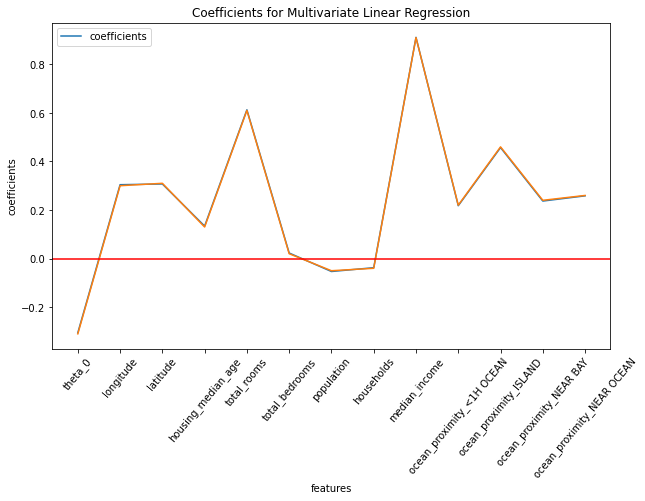

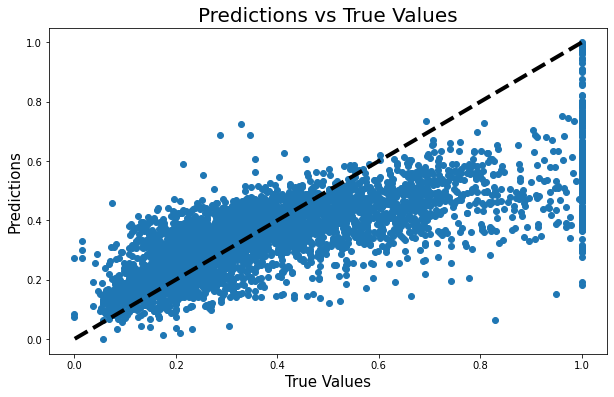

In [26]:
from IPython.display import clear_output

y_predict = hypothesis(x_test, history_theta[-1])
y_test = np.array(y_test).reshape(y_test.shape[0],)

print("y_predict: ", y_predict)
print("y_test: ", y_test)

report_error = pd.DataFrame({"mse": [calculate_mse(y_predict, y_test)], "rmse": [calculate_rmse(y_predict, y_test)], "mae": [
                            calculate_mae(y_predict, y_test)], "mape": [calculate_mape(y_predict, y_test)], "r_squared": [calculate_r_squared(y_predict, y_test)]})
print(report_error)

report = report_difference(y_predict, y_test)
report_diff_mean = report_difference_mean(report)
# print(report)
# print("difference mean: ",report_diff_mean)

# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_predict)
# plt.plot([y_test.min(), y_test.max()], [
#          y_test.min(), y_test.max()], 'k--', lw=4)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.show()

print(history_theta[:10]) 

coeffs = pd.DataFrame({"theta": history_theta[-1], "coeff": history_theta[-1]})
coeffs["coeff"] = coeffs["coeff"].apply(lambda x: np.round(x, 2))
# print(coeffs)

# for i in range(10):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(y_test, hypothesis(x_test, history_theta[i]))
#     clear_output(wait=True)
#     plt.plot([y_test.min(), y_test.max()], [y_predict.min(), y_predict.max()], 'k--', lw=4)
#     # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
#     plt.xlabel('True Values')
#     plt.ylabel('Predictions')
#     # save images in ./images 
#     plt.savefig("./images/plot_" + str(i) + ".png")

# rescale coeffs to 0-1 range
# coeffs["coeff"] = coeffs["coeff"].apply(lambda x: (x - min(coeffs["coeff"])) / (max(coeffs["coeff"]) - min(coeffs["coeff"])))

plt.figure(figsize=(10, 6))
plt.plot(range(len(coeffs)), coeffs)
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)), feature_columns, rotation=50)
plt.title("Coefficients for Multivariate Linear Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.legend(["coefficients"], loc="upper left")
plt.show()

#  ffmpeg -framerate 30 -pattern_type glob -i 'plot_*.png' -c:v libx264 -pix_fmt yuv420p out.mp4 ####30 fps####

# y_test = np.array(y_test)

# rescaling y_test and y_predict to original scale

y_test_scaled = y_test
y_predict_scaled = y_predict

y_test_scaled = (y_test - y_test.min())/(y_test.max() - y_test.min())
y_predict_scaled = (y_predict - y_predict.min())/(y_predict.max() - y_predict.min())

plt.figure(figsize=(10,6))
plt.scatter(y_test_scaled, y_predict_scaled)
p1 = max(max(y_predict_scaled), max(y_test_scaled))
p2 = min(min(y_predict_scaled), min(y_test_scaled))
plt.plot([p1, p2], [p1, p2], 'k--', lw=4)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Predictions vs True Values', fontsize=20)
plt.show()

### =================================================================================================

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 
from sklearn.datasets import make_regression
from JSAnimation import IPython_display

# Explanatory Data Analysis (EDA)

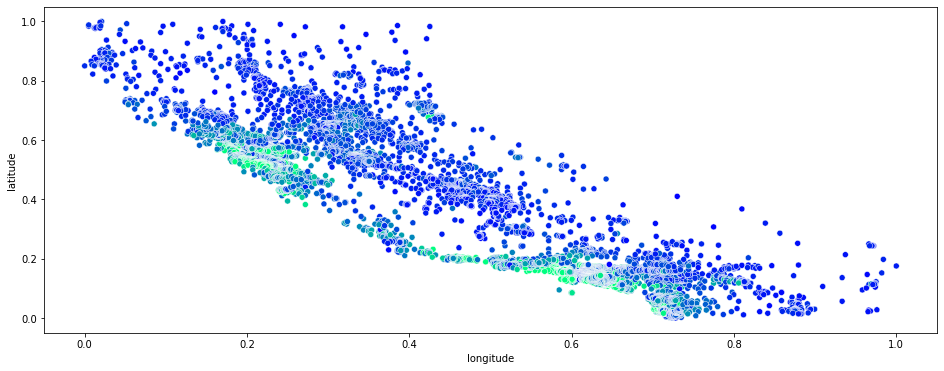

In [53]:
df = copy_df(dataset)

# Housing distribution on the map
plt.figure(figsize=(16,6))
fig = sns.scatterplot(df.longitude, df.latitude, hue=df['median_house_value'],
                      legend=False, palette='winter')

In [54]:
# Correlation matrix
df.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069260,0.099773,0.055310,-0.015176,0.321121,0.009446,-0.474489,0.045509,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066658,-0.108785,-0.071035,-0.079809,-0.446969,-0.016572,0.358771,-0.160818,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.318998,-0.296244,-0.302916,-0.119034,0.045300,0.017020,0.255172,0.021622,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927253,0.857126,0.918484,0.198050,-0.003031,-0.007572,-0.023022,-0.009175,0.134153
total_bedrooms,0.069260,-0.066658,-0.318998,0.927253,1.000000,0.873910,0.974725,-0.007682,0.018220,-0.004361,-0.019785,0.000676,0.049454
population,0.099773,-0.108785,-0.296244,0.857126,0.873910,1.000000,0.907222,0.004834,0.074613,-0.010412,-0.060880,-0.024264,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.974725,0.907222,1.000000,0.013033,0.042435,-0.009077,-0.010093,0.001714,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007682,0.004834,0.013033,1.000000,0.168876,-0.009228,0.056197,0.027344,0.688075
ocean_proximity_<1H OCEAN,0.321121,-0.446969,0.045300,-0.003031,0.018220,0.074613,0.042435,0.168876,1.000000,-0.013872,-0.314813,-0.342620,0.256617
ocean_proximity_ISLAND,0.009446,-0.016572,0.017020,-0.007572,-0.004361,-0.010412,-0.009077,-0.009228,-0.013872,1.000000,-0.005499,-0.005985,0.023416


<AxesSubplot:title={'center':'Correlation Matrix'}, xlabel='Features'>

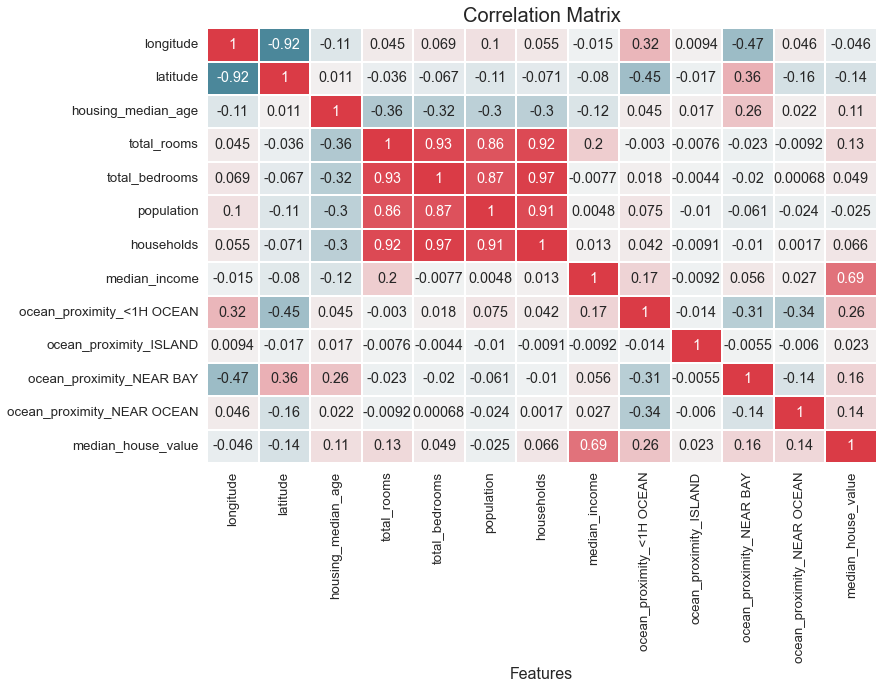

In [55]:
def correlation_heatmap(data):
    """arguments: data_frame:pandas DataFrame
       returns: correlation heatmap"""
    
    #  setting the context
    sns.set(context='paper', style='white', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
    
    #  making correlation object and saving it into variable
    correlation = data.corr()
    
    #  creating heatmap figure object (paper) and ax object (the plot)
    fig, ax = plt.subplots(figsize=(12, 8))
    
    #  generating color palettes
    cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
    
    #  draw the heatmap
    heatmap = sns.heatmap(correlation, vmax=1,vmin=-1,center=0, square=False, annot=True, cmap=cmap,
                         lw=2, cbar=False)
    
    # using fig and ax variables to set the title and labels
    heatmap.set_title('Correlation Matrix', fontsize=20)
    heatmap.set_xlabel('Features', fontsize=16)
    
    return heatmap

correlation_heatmap(df)

In [6]:
import os
import math
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

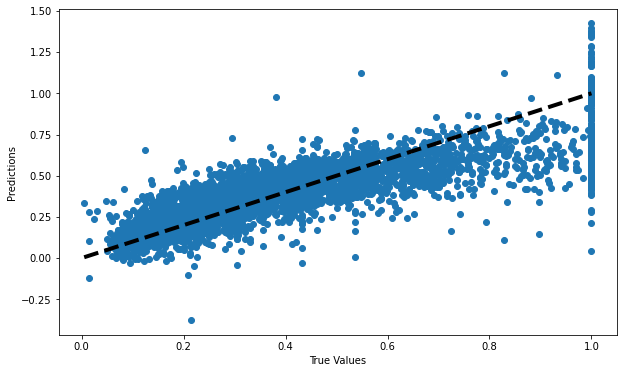

-0.020042918814001977
[0.41595067]
[ 0.         -0.55932788 -0.49483336  0.11158626 -0.52094432  1.467754
 -2.78026024  0.50599421  1.17703152  0.0824092   0.39362237  0.07121773
  0.08905665]


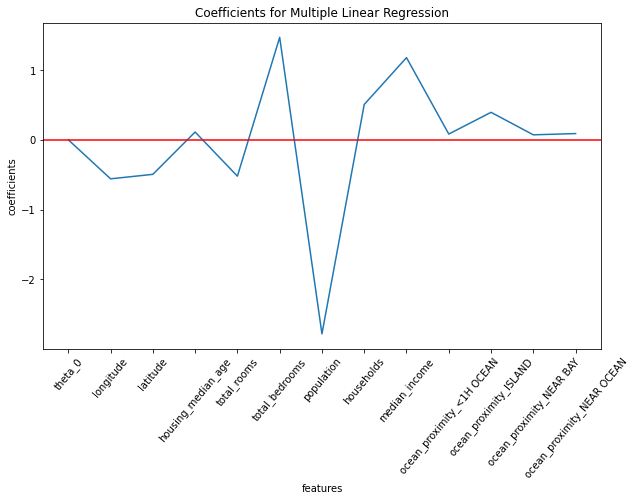

[[0.05422864]
 [0.11134181]
 [0.31443375]
 ...
 [0.82948318]
 [0.43608274]
 [0.63525717]] [[0.25907599]
 [0.06985368]
 [0.49185034]
 ...
 [0.67828922]
 [0.37260494]
 [0.5216024 ]]


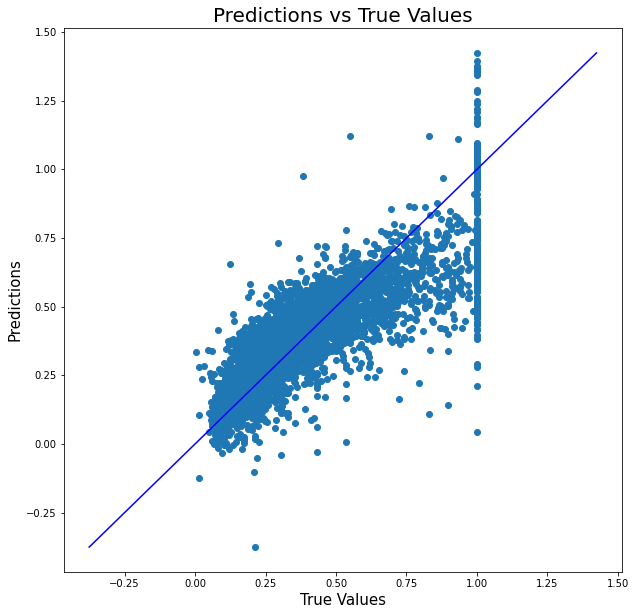

In [7]:
dataset = load("housing.csv")
dataset = normalize_missing_values(dataset)
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")

dataset = dummy_variable_indicator(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

dataset = normalize_numerical_columns(dataset)

dataset.insert(0, "theta_0", np.ones(dataset.shape[0]))

X = dataset.drop('median_house_value', axis=1)
y = dataset[['median_house_value']]

feature_columns = list(X.columns)

# split dataset into train, validation and test - 80% train, 10% validation and 10% test with sklearn


SEED = 42
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.4, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

# print(x_train.head(), y_train.head())
# print(x_validation.head(), y_validation.head())

regressor = LinearRegression()
model = regressor.fit(x_train, y_train)
y_predict = model.predict(x_test)

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

mse = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(mse.mean())

multiple_lr_coeffs = model.coef_[0]
print(model.intercept_)
print(multiple_lr_coeffs)

plt.figure(figsize=(10,6))
plt.plot(range(len(multiple_lr_coeffs)),multiple_lr_coeffs)
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Multiple Linear Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.show()

y_test = np.array(y_test)
y_test_scaled = y_test
y_predict_scaled = y_predict
# rescaling y_test and y_predict between -1 and 1
# y_test_scaled = (y_test - y_test.min())/(y_test.max() - y_test.min())
# y_predict_scaled = (y_predict - y_predict.min())/(y_predict.max() - y_predict.min())

print(y_test_scaled, y_predict_scaled)

plt.figure(figsize=(10,10))
plt.scatter(y_test_scaled, y_predict_scaled)
p1 = max(max(y_predict_scaled), max(y_test_scaled))
p2 = min(min(y_predict_scaled), min(y_test_scaled))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title('Predictions vs True Values', fontsize=20)
plt.show()


In [58]:
x_train.corr().style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
longitude,1.000000,-0.923981,-0.105167,0.040254,0.067978,0.099033,0.054140,-0.018263,0.318957,0.009828,-0.471625,0.039843
latitude,-0.923981,1.000000,0.008003,-0.032579,-0.065859,-0.108276,-0.069372,-0.077705,-0.448669,-0.016882,0.355986,-0.153636
housing_median_age,-0.105167,0.008003,1.000000,-0.360765,-0.318483,-0.293700,-0.300811,-0.117351,0.038559,0.018719,0.257925,0.030750
total_rooms,0.040254,-0.032579,-0.360765,1.000000,0.928249,0.856030,0.920379,0.198950,0.000073,-0.004257,-0.024612,-0.019292
total_bedrooms,0.067978,-0.065859,-0.318483,0.928249,1.000000,0.878468,0.982014,-0.011577,0.022405,0.000087,-0.021619,-0.010365
population,0.099033,-0.108276,-0.293700,0.856030,0.878468,1.000000,0.905168,0.002187,0.076275,-0.007894,-0.063179,-0.033262
households,0.054140,-0.069372,-0.300811,0.920379,0.982014,0.905168,1.000000,0.010285,0.043745,-0.006190,-0.012982,-0.008581
median_income,-0.018263,-0.077705,-0.117351,0.198950,-0.011577,0.002187,0.010285,1.000000,0.174705,-0.008851,0.053144,0.025225
ocean_proximity_<1H OCEAN,0.318957,-0.448669,0.038559,0.000073,0.022405,0.076275,0.043745,0.174705,1.000000,-0.013937,-0.317702,-0.335765
ocean_proximity_ISLAND,0.009828,-0.016882,0.018719,-0.004257,0.000087,-0.007894,-0.006190,-0.008851,-0.013937,1.000000,-0.005524,-0.005838


In [59]:
alpha_values = {'alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06, 0.07, 0.075, 0.08, 0.09,0.1,0.2,0.3,0.31,0.32,0.33,0.34, 0.35, 0.351, 0.352, 0.0353, 0.0354, 0.355 , 0.356 ,0.357, 0.358, 0.359 ,0.36, 0.37,0.38, 0.39, 0.4, 0.45, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
ridge= GridSearchCV(Ridge(), alpha_values, scoring='neg_mean_squared_error', cv=10 )
ridge.fit(x_train, y_train)
print(ridge.best_params_)

{'alpha': 0.3}


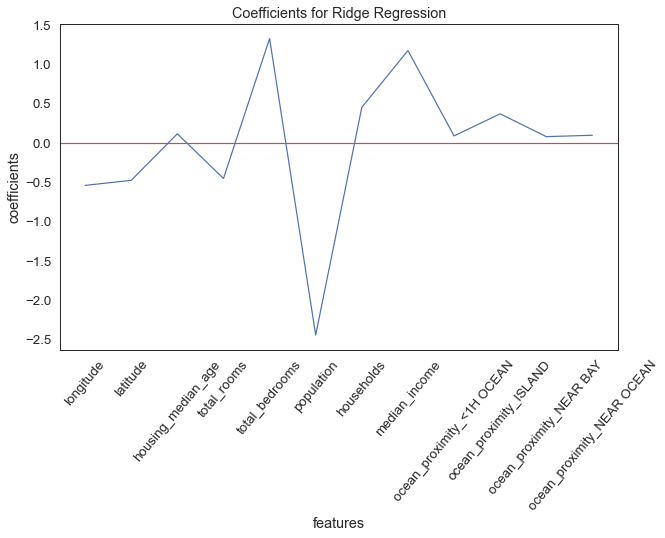

In [21]:
best_ridge_model= Ridge(alpha=ridge.best_params_['alpha'])
best_ridge_coeffs = best_ridge_model.fit(x_train, y_train).coef_
# print(best_ridge_coeffs)
#plot 
plt.figure(figsize=(10,6))
plt.plot(range(len(feature_columns)),best_ridge_coeffs[0])
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Ridge Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.show()

In [22]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
alpha_values = {'alpha':[0.001, 0.01,0.02,0.03,0.04, 0.05, 0.06,0.07, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100]}
lasso = GridSearchCV(Lasso(), alpha_values, scoring='neg_mean_squared_error', cv=10 )
lasso_fit = lasso.fit(x_train, y_train)
print(lasso_fit.best_params_)
print(lasso_fit.best_score_)

{'alpha': 0.001}
-0.02262223714466208


[-0.01894358 -0.          0.08820824  0.          0.08105182 -0.
  0.          1.08835328  0.14311988  0.          0.15631366  0.16910718]


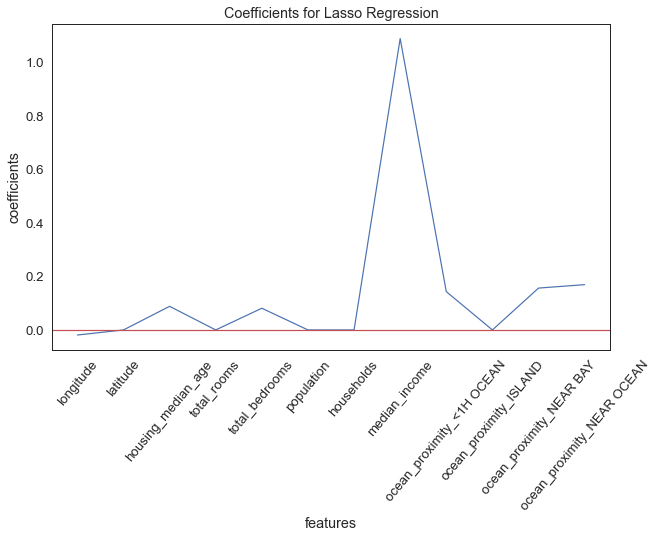

In [23]:
best_lasso_model= Lasso(alpha=lasso_fit.best_params_['alpha'])
best_lasso_coeffs = best_lasso_model.fit(x_train, y_train).coef_

print(best_lasso_coeffs)

# plot
plt.figure(figsize=(10,6))
plt.plot(range(len(feature_columns)),best_lasso_coeffs)
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Lasso Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.show()


In [24]:
alpha_values = {'alpha':[0.00005,0.0005,0.001, 0.01, 0.05, 0.06, 0.08, 1, 2, 3, 5, 8, 10, 20, 50, 100], 'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1]}
elastic = GridSearchCV(ElasticNet(), alpha_values, scoring='neg_mean_squared_error', cv=10 )
elastic_fit = elastic.fit(x_train, y_train)
print(elastic_fit.best_params_)
print(elastic_fit.best_score_)

{'alpha': 5e-05, 'l1_ratio': 0.1}
-0.020022723074219335


In [27]:
best_elastic_coeefs = elastic_fit.best_estimator_.coef_


In [28]:
# compare models with different regularization parameters
comparing_models = [('Linear Regression', LinearRegression()), ('Ridge Regression', Ridge()), ('Lasso Regression', Lasso()), ('Elastic Net', ElasticNet())]

comparing_models = pd.DataFrame({'without_regularization':multiple_lr_coeffs,
 'Ridge':best_ridge_coeffs[0],
 'Lasso':best_lasso_coeffs,
  'Elastic Net':best_elastic_coeefs}, index=feature_columns)
# Highlighting coefficient estimates with value '0'
comparing_models.style.background_gradient(cmap='coolwarm')

comparing_models

,without_regularization,Ridge,Lasso,Elastic Net
longitude,-0.559328,-0.544001,-0.018944,-0.529858
latitude,-0.494833,-0.479799,-0.000000,-0.466202
housing_median_age,0.111586,0.111736,0.088208,0.111890
total_rooms,-0.520944,-0.456392,0.000000,-0.385181
total_bedrooms,1.467754,1.322090,0.081052,1.202111
population,-2.780260,-2.444812,-0.000000,-2.190567
households,0.505994,0.447080,0.000000,0.393381
median_income,1.177032,1.169511,1.088353,1.161442
ocean_proximity_<1H OCEAN,0.082409,0.084638,0.143120,0.086829
ocean_proximity_ISLAND,0.393622,0.365103,0.000000,0.326808


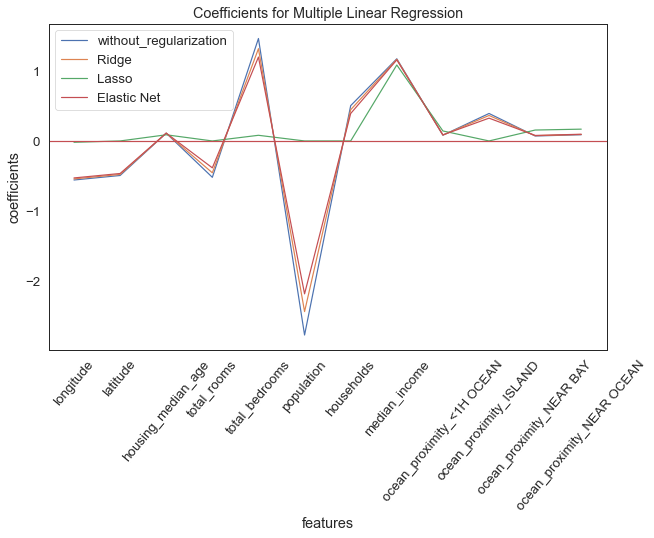

In [31]:
plt.figure(figsize=(10,6))
plt.plot(range(len(feature_columns)),comparing_models['without_regularization'], label='without_regularization')
plt.plot(range(len(feature_columns)),comparing_models['Ridge'], label='Ridge')
plt.plot(range(len(feature_columns)),comparing_models['Lasso'], label='Lasso')
plt.plot(range(len(feature_columns)),comparing_models['Elastic Net'], label='Elastic Net')
plt.axhline(0, color='r', linestyle='solid')
plt.xticks(range(len(feature_columns)),feature_columns,rotation=50)
plt.title("Coefficients for Multiple Linear Regression")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.legend()
plt.show()

[array([[-4.63166210e+000, -4.93612364e+000, -4.73418370e+000, ...,
         1.91254291e-001,  5.36604272e+000, -7.32005016e-002],
       [ 3.52232369e+000,  3.45142237e+000,  3.40246228e+000, ...,
        -2.20094620e-001, -4.17827089e+000, -1.18715367e-001],
       [ 6.02448058e+000,  6.22240668e+000,  6.18064670e+000, ...,
        -8.58000664e-002, -7.24467465e+000, -2.89115143e-001],
       ...,
       [ 2.66796544e+000,  2.69473756e+000,  2.64116530e+000, ...,
         7.84839901e-277, -2.71981670e+000,  1.17727266e-002],
       [ 1.02326373e+001,  1.04130876e+001,  1.04256224e+001, ...,
        -6.74643660e-002, -1.08070405e+001,  5.33214305e-002],
       [ 1.17477531e+001,  1.15921363e+001,  1.15811938e+001, ...,
        -1.45405388e-001, -1.16547859e+001, -2.36328788e-001]]), array([[ 8.32493212e+000],
       [ 2.88810541e+000],
       [ 2.13025326e+000],
       [ 2.53060134e+000],
       [ 5.69594606e+000],
       [-3.62795610e+000],
       [-1.55372408e-237],
       [ 1.81438

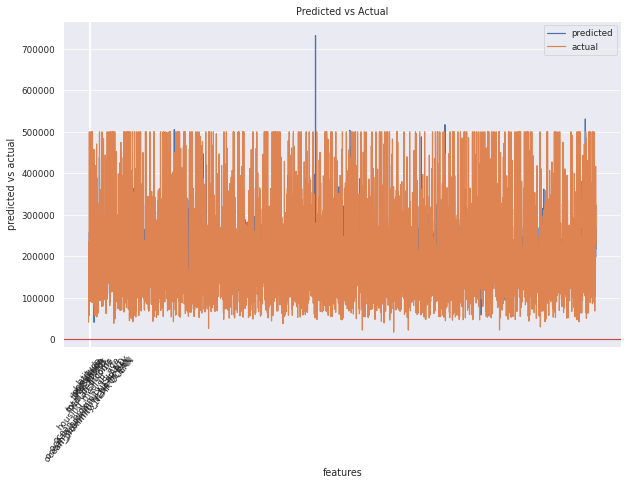

MSE: 9958965014.73
MAE: 77834.51
R2: 0.27


In [52]:
# solve same problem with neural network
from sklearn.neural_network import MLPRegressor
dataset = load("housing.csv")
dataset = normalize_missing_values(dataset)
last_column = dataset[["median_house_value"]]
dataset = remove_column(dataset, "median_house_value")
dataset = dummy_variable_indicator(dataset, "ocean_proximity")
dataset = remove_column(dataset, "ocean_proximity_INLAND")
dataset = concat_data(dataset, last_column)

# dataset = normalize_numerical_columns(dataset)

X = dataset.drop('median_house_value', axis=1)
y = dataset[['median_house_value']]

feature_columns = list(X.columns)

# split dataset into train, validation and test - 80% train, 10% validation and 10% test with sklearn

SEED = 42
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(
    X, y, test_size=.4, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(
    x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
                   random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# fit the model with regularization
mlp.fit(x_train, y_train)
mlp.score(x_train, y_train)
mlp.score(x_validation, y_validation)
mlp.score(x_test, y_test)

print(mlp.coefs_)
print(mlp.intercepts_)

# predict the test set
y_pred = mlp.predict(x_test)


# MSE, MAE, R2
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
print("MAE: %.2f" % mean_absolute_error(y_test, y_pred))
print("R2: %.2f" % r2_score(y_test, y_pred))


# Q2: Logistic Regression

In [32]:
# print(">======================= Loading ====================<")
dataset = load("data_banknote_authentication.txt", False)
# print(">=====================================================")

# print(">============ Data without missing values ===========<")
dataset = normalize_missing_values(dataset)
# last_column = dataset[["median_house_value"]]
# dataset = remove_column(dataset, "median_house_value")
dataset.rename(columns={0: 'column_1', 1: 'column_2', 2: 'column_3', 3: 'column_4', 4:'label' }, inplace=True)
# print_dataset(dataset)
dataset.tail()

# print(">=====================================================")

# print(">===== One-hot encoder for categorical data =========<")
# dataset = dummy_variable_indicator(dataset, "ocean_proximity")
# dataset = remove_column(dataset, "ocean_proximity_INLAND")
# dataset = concat_data(dataset, last_column)
# print(">=====================================================")

# for part H of the assignment
# dataset_for_part_h = copy_df(dataset)
# print(">================== Normalized data =================<")
# dataset = normalize_numerical_columns(dataset)
# print_dataset(dataset)
# print(dataset.head())
# print(">=====================================================")

# print(">====== 60% train, 20% validation and 20% test =======")
# k_fold_number = 5
# x_train_list, y_train_list, x_test_list, y_test_list, x_validation_list, y_validation_list = k_fold(copy_df(dataset), k_fold_number)

# print_k_fold_data(x_train_list, y_train_list, x_test_list, y_test_list, x_validation_list, y_validation_list)


,column_1,column_2,column_3,column_4,label
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1
1371,-2.54190,-0.65804,2.6842,1.19520,1


In [33]:
X = dataset[['column_1', 'column_2', 'column_3', 'column_4']].values
y = dataset['label'].values.reshape(-1, 1)

In [34]:
# logistic regression untility function
def logistic(z):
    return 1 / (1 + np.exp(-z))

M, N = X.shape
X = np.concatenate((np.ones((M, 1)), X), axis=1)
print(X)

[[  1.        3.6216    8.6661   -2.8073   -0.44699]
 [  1.        4.5459    8.1674   -2.4586   -1.4621 ]
 [  1.        3.866    -2.6383    1.9242    0.10645]
 ...
 [  1.       -3.7503  -13.4586   17.5932   -2.7771 ]
 [  1.       -3.5637   -8.3827   12.393    -1.2823 ]
 [  1.       -2.5419   -0.65804   2.6842    1.1952 ]]


In [35]:
alpha = 0.5
epsilon = 0.12

weights = 2*np.random.rand(N+1, 1)*epsilon - epsilon

oldJ = 0
err = 1

Js = []
count = 0

while err > 1e-3:
    Zs = np.dot(X, weights)
    Hs = logistic(Zs) # phi
    
    deltas = alpha/M*np.dot(X.T, (Hs-y))
    weights -= deltas

    count += 1

    # Cross Entropy
    J = -1/M*(np.dot(y.T, np.log(Hs)) + np.dot(1-y.T, np.log(1-Hs)))
    
    Js.append(float(J))
    err = np.abs(oldJ-J)
    oldJ = J
    
    if count % 10 == 0:
        print(count, J, err, weights.flatten())

print(count, J, err, weights.flatten())

10 [[0.12547923]] [[0.00454762]] [ 0.34990808 -1.07691658 -0.53655805 -0.54498501 -0.23275809]
20 [[0.09725384]] [[0.00199153]] [ 0.59085059 -1.25321745 -0.6668041  -0.6996085  -0.26557674]
30 [[0.0822278]] [[0.00120257]] [ 0.7861224  -1.37270143 -0.7548469  -0.80807973 -0.27413342]
35 [[0.07689934]] [[0.00098395]] [ 0.87154032 -1.42137343 -0.79050236 -0.85264076 -0.27451604]


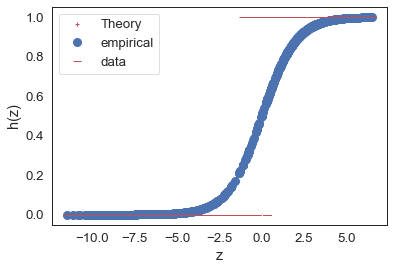

In [43]:
def plot_boundary(Zs, Hs, y):
    data_fit = np.concatenate((Zs, Hs), axis=1)
    data_fit.sort(axis = 0)

    z = np.linspace(Zs.min(), Zs.max(), 100)

    plt.plot(z, logistic(z), 'r+', label='Theory')
    plt.plot(Zs, Hs, 'o', label='empirical', markersize=8)
    plt.plot(Zs, y, 'r_', label = 'data', markersize=8)
    plt.xlabel('z')
    plt.ylabel('h(z)')
    #plt.title('Logistic Regression')
    plt.legend()

plot_boundary(Zs, Hs, y)


ValueError: shapes (5,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)

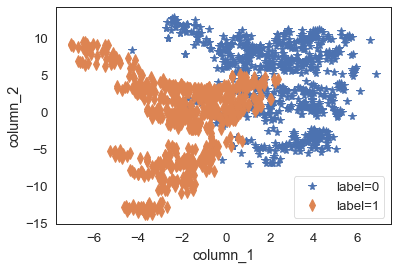

In [37]:
def plot_points(data, features, weights, label='label'):
    plt.plot(data[features[0]][data[label]==0], 
             data[features[1]][data[label]==0], '*', label='label=0', markersize=8)
    
    plt.plot(data[features[0]][data[label]==1], 
             data[features[1]][data[label]==1], 'd', label='label=1', markersize=8)

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()

plot_points(dataset, ['column_1', 'column_2'], weights)


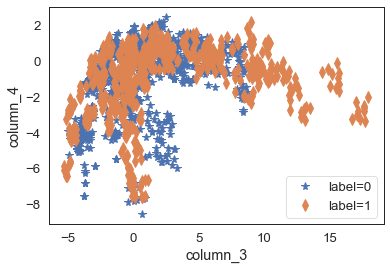

In [38]:
plot_points(dataset, ['column_3', 'column_4'], weights)
